In [ ]:
!pip install pyopencl

import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Input

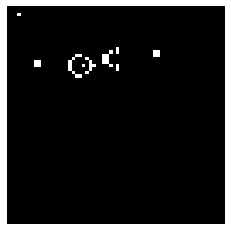

In [52]:
# Definitions of the size of the matrix and the number of iterations to run
N = 64
K = 10
# To test the second pattern.
# K = 600

# Living cells in the initial state.
L = [[8,16],[8,17],[9,16],[9,17],[3,2],[18,16],[18,17],[18,18],[19,15],[19,19],
     [20,14],[20,20],[21,14],[21,20],[22,17],[23,15],[23,19],[24,16],[24,18],[24,17],
     [25,17],[28,16],[28,15],[28,14],[29,16],[29,15],[29,14],[30,17],[30,13], [32,17],[32,13],
     [32,18],[32,12],[43,13],[44,13],[43,14],[44,14]]

# Another pattern.
# L = [[31,31], [32,31], [31,32], [31,30], [30,30]]

# Test pattern.
# N = 45
# K = 10
# L = [[2,3], [3,3], [2,4], [3,4], [7,3], [7,4], [7,5], [7,6], [2,14], [3,14], [4,14],
#      [2,15], [7,14], [8,15], [9,15], [10,15], [4,21], [2,22], [3,22], [3,23], [7,33], [6,34], [7,34], [8,34]]

#Generate initial matrix
initial_matrix = np.zeros(N*N, dtype=np.int32)
for p in L:
  initial_matrix[(p[1]*N)+p[0]]= 1


#Show the initial matrix. 
fig, ax = plt.subplots()
ax.imshow(np.reshape(initial_matrix,(N,N)), cmap='gray')
plt.axis('off')
plt.show()

# Kernel

In [53]:
KernelSource = """
__kernel void Conway(
    __global const int *data_g,
    __global int *res_g,
    const int N
)
  {
    const int x = get_global_id(0);
    const int y = get_global_id(1);
    int vecinosVivos = 0;

    if (x != 0) { // Vecino izquierdo
      vecinosVivos += data_g[y*N+x-1];
    }
    if (x != (N-1)) { // Vecino derecho
      vecinosVivos += data_g[y*N+x+1];
    }
    if (y != 0) { // Vecino superior
      vecinosVivos += data_g[(y-1)*N+x];
    }
    if (y != (N-1)) { // Vecino inferior
      vecinosVivos += data_g[(y+1)*N+x];
    }
    if (x != 0 && y != 0) { // Vecino superior izquierdo
      vecinosVivos += data_g[(y-1)*N+x-1];
    }
    if (x != (N-1) && y != 0) { // Vecino superior derecho
      vecinosVivos += data_g[(y-1)*N+x+1];
    }
    if (x != 0 && y != (N-1)) { // Vecino inferior izquierdo
      vecinosVivos += data_g[(y+1)*N+x-1];
    }
    if (x != (N-1) && y != (N-1)) { // Vecino inferior derecho
      vecinosVivos += data_g[(y+1)*N+x+1];
    }
    int estado = 0;
    
    if (data_g[y*N+x]) {
      if (vecinosVivos == 2 || vecinosVivos == 3) {
        estado = 1;
      }
    } else if (vecinosVivos == 3) {
        estado = 1;
    }

    res_g[y*N+x] = estado;
  
  }

"""

En este ejercicio utilizamos descomposición de datos de salida, no sería posible resolverlo con descomposición de datos de entrada ya que para calcular una celda de la salida hacemos uso de más de una celda de entrada. 

# Inicialización del host


In [54]:
# Obtener la plataforma
plataform_list = cl.get_platforms()

# Obtener los dispositivos
devices = plataform_list[0].get_devices(device_type = cl.device_type.GPU)

# Crear el contexto
context = cl.Context(devices=devices)

# Crear el Command Queue
queue = cl.CommandQueue(
    context,
    properties= cl.command_queue_properties.PROFILING_ENABLE
)

# Crear e inicializar el vector (bidimensional) de salida
res_np = np.empty_like(initial_matrix)

# Crear e inicializar los Buffers (OpenCL)
data_g = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf = initial_matrix)
res_g = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = res_np)

# Crear el programa
program = cl.Program(context, KernelSource).build()

# Crear el kernel
kernel = program.Conway

# Configurar los argumentos
kernel.set_scalar_arg_dtypes([None, None, np.int32])
kernel.set_args(data_g, res_g, N)

# Definir el espacio indexado
globalRange = (N, N)
localRange = None

Utilizamos sincronismo a nivel de host mediante el uso de una cola de comandos en orden (configuración por default al crear la Command Queue y no indicar que debe ser out of order), por lo que no es necesario esperar a que finalice un evento antes de encolar el siguiente.


# Output

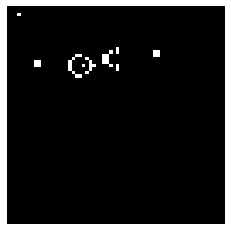

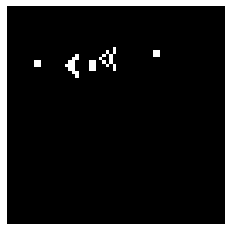

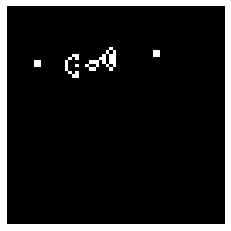

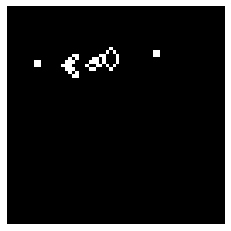

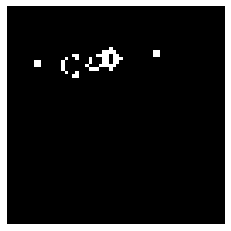

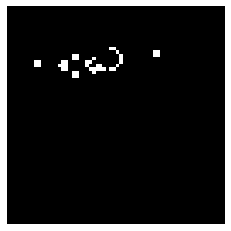

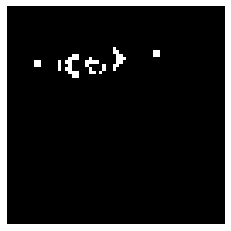

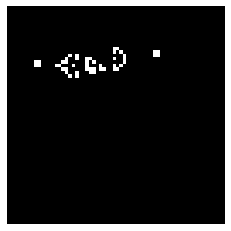

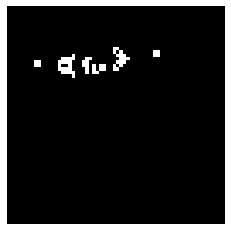

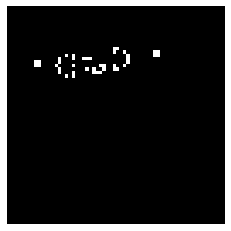

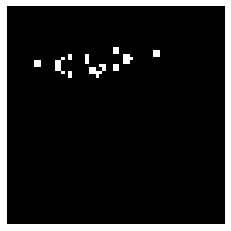

In [55]:
fig, ax = plt.subplots()
ax.imshow(np.reshape(initial_matrix,(N,N)), cmap='gray')
plt.axis('off')
plt.show()

frames = []

for i in range(K):
  kernel.set_scalar_arg_dtypes([None, None, np.int32])
  kernel.set_args(data_g, res_g, N)
  ev = cl.enqueue_nd_range_kernel(queue, kernel, globalRange, localRange)
  copy_ev = cl.enqueue_copy(queue, res_np, res_g)
  frames.append(res_np)
  
  # El siguiente data_g tiene que ser el resultado de esta iteración
  data_g = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = res_np)
  # Limpiamos el res_g
  empty_ev = cl.enqueue_fill_buffer(queue, res_g, np.uint32(0), 0, N*N)

  fig, ax = plt.subplots()
  ax.imshow(np.reshape(res_np,(N,N)), cmap='gray')
  plt.axis('off')
  plt.show()

# Inicializar buffers con contenido original para la próxima ejecución de este bloque
data_g = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = initial_matrix)